In this example, we will try to estimate the phase of the eigenvalue of the $S$ gate that corresponds to the eigenvector $|1\rangle$.

In [1]:
using SymbolicQuantumSimulator
using StatsPlots
using SymPy

┌ Warning: The project dependencies or compat requirements have changed since the manifest was last resolved.
│ It is recommended to `Pkg.resolve()` or consider `Pkg.update()` if necessary.
└ @ Pkg.API ~/.julia/juliaup/julia-1.10.7+0.x64.linux.gnu/share/julia/stdlib/v1.10/Pkg/src/API.jl:1848
[ Info: Precompiling StatsPlotsExt [c98267f3-c073-5a6e-bd72-cc0fa896355a]


In [2]:
Base.retry_load_extensions()

We will use the IQFT circuit, which is also used in the Shor's algorithm example notebook.

In [3]:
function iqft(n::Integer)
    qreg = QuantumRegister(n, "q")
    qc = QuantumCircuit(qreg...)
    
    for i = n ÷ 2:-1:1
        push!(qc, SwapGate(qreg[i], qreg[n + 1 - i]))
    end
    
    for control = 1:n
        push!(qc, HGate(qreg[control]))
    
        k = 2
            for target = control+1:n
            push!(qc, CPGate(-Sym(2) / Sym(2) ^ k * PI, qreg[control], qreg[target]))
            k += 1
        end
    end
    
    return qc
end

iqft (generic function with 1 method)

The IQFT circuit for 3 qubits looks like this:

In [4]:
draw(iqft(3))

        ┌───┐                                           
q_1: ─X─┤ H ├─────■──────────■──────────────────────────
      │ └───┘┌────┴────┐     │     ┌───┐                
q_2: ─┼──────┤ P(-π/2) ├─────┼─────┤ H ├─────■──────────
      │      └─────────┘┌────┴────┐└───┘┌────┴────┐┌───┐
q_3: ─X─────────────────┤ P(-π/4) ├─────┤ P(-π/2) ├┤ H ├
                        └─────────┘     └─────────┘└───┘


Now we can construct the main circuit for phase estimation:

In [16]:
# Number of qubits, determines the approximation resolution
t = 3

qfirst = QuantumRegister(t, "q_first")
qsecond = QuantumRegister(1, "q_second")

qc = QuantumCircuit(qfirst..., qsecond...)

# Initialize the first register
append!(qc, HGate.(qfirst))

# Initialize the second register to the eigenvector |1>
push!(qc, XGate(qsecond[1]))

push!(qc, Barrier())

# Apply CT repeatedly
for control = 1:t
    reps = 2 ^ (control - 1)
    for i = 1:N(reps)
        push!(qc, CSGate(qfirst[control], qsecond[1]))
    end
end

# Apply IQFT
push!(qc, circuit_to_gate(iqft(length(qfirst)), qfirst...; name="IQFT"))

push!(qc, Barrier())

# Measure the qubits in the first register
append!(qc, Measurement.(qfirst))

In [17]:
draw(qc)

            ┌───┐                                      ┌───────┐   ┌─┐      
 q_first_1: ┤ H ├─░───■────────────────────────────────┤1      ├─░─┤@├──────
            ├───┤ ░   │                                │       │ ░ └─┘┌─┐   
 q_first_2: ┤ H ├─░───┼────■────■──────────────────────┤2 IQFT ├─░────┤@├───
            ├───┤ ░   │    │    │                      │       │ ░    └─┘┌─┐
 q_first_3: ┤ H ├─░───┼────┼────┼────■────■────■────■──┤3      ├─░───────┤@├
            ├───┤ ░ ┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐└───────┘ ░       └─┘
q_second_1: ┤ X ├─░─┤ S ├┤ S ├┤ S ├┤ S ├┤ S ├┤ S ├┤ S ├──────────░──────────
            └───┘   └───┘└───┘└───┘└───┘└───┘└───┘└───┘                     


In [18]:
results = simulate_measurements(qc; simplification = true)

Dict{String, Sym} with 8 entries:
  "000" => 0
  "111" => 0
  "001" => 0
  "011" => 0
  "101" => 0
  "110" => 0
  "010" => 1
  "100" => 0

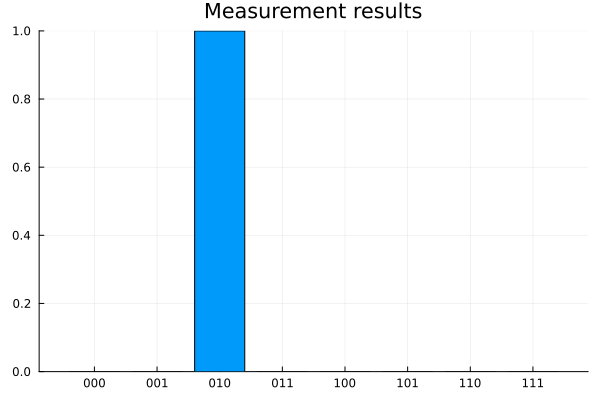

In [19]:
plot_measurements(results)

We can see that the phase if the eigenvalue of $S$ corresponding to the eigenvector $|1\rangle$ is estimated to be $\frac{2}{8}\cdot 2\pi = \frac{\pi}{2}$. That is indeed a correct estimation, as

$$S|1\rangle = \begin{pmatrix}1&0\\0&i\end{pmatrix}\begin{pmatrix}0\\1\end{pmatrix} = \begin{pmatrix}0\\i\end{pmatrix} = i|1\rangle = e^{\frac{\pi}{2}}|1\rangle.$$